### **Deeper Networks**

---

### **1. Why Deeper Networks? (and Reload CIFAR-10)**

In the previous notebook, we worked with the **CIFAR-10 dataset** and trained a **simple Multi-Layer Perceptron (MLP)** — a shallow neural network with just one hidden layer.

That model gave us a decent starting point, but also showed clear **limitations**:

- It could only capture relatively simple patterns.
- Accuracy plateaued despite further training.
- It lacked the ability to model **hierarchical** or **abstract** representations.

> 🧠 Why Go Deeper?

A **deeper network** — one with more layers — has more **representational power**. In theory, it can:

- Learn more **complex, non-linear patterns**,
- Capture **hierarchical features** (e.g., edges → textures → objects),
- Offer **better generalization** on large, rich datasets like CIFAR-10.

But deeper isn’t always better — deeper models are **harder to train**.

They often suffer from:

- ⚠️ **Vanishing gradients**: updates become too small to be useful.
- ⚠️ **Exploding gradients**: updates become too large and unstable.
- ⚠️ **Unstable training dynamics**: losses oscillate or fail to converge.

So before diving deeper, we need a solid pipeline in place — and that starts with **preparing the dataset**.

>**Recap: CIFAR-10 Preprocessing**

We already saw that CIFAR-10 images have shape `[3, 32, 32]` — 3 color channels and 32×32 pixels.

For MLPs, we **flatten** these into 1D vectors of length **3072 = 3×32×32**. We also **normalize** pixel values from `[0, 255]` to `[0.0, 1.0]` using `transforms.ToTensor()`.

Let’s reload the dataset with these transformations applied.

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# set manual seed for reproducibility
torch.manual_seed(42)
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))
    ]
)

train_val_data = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_data      = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
train_val_data.__len__()

50000

In [4]:
# split train_val data 
train_size = int(len(train_val_data) * 0.9)
val_size   = len(train_val_data) - train_size
train_data, val_data = random_split(train_val_data, [train_size, val_size])

# Wrap in data loader
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_data, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

# get classes
class_names = train_val_data.classes

# print batches and shapes of image
print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")
print(F"Input Dimension: {next(iter(train_loader))[0].shape}")
print(f"Number of classes: {len(class_names)}")

Train batches: 704
Validation batches: 79
Test batches: 157
Input Dimension: torch.Size([64, 3072])
Number of classes: 10


- **Train batches: 704**: 45,000 training images divided into mini-batches of 64. => $\frac{45000}{64} \approx 704$ batches.

- **Validation batches: 79**: 5,000 validation images in batches of 64. => $\frac{5000}{64} \approx 79$ batches.

- **Test batches: 157**: Same logic as validation — CIFAR-10 test set has 10,000 images.

- **Image shape (flattened):** CIFAR-10 images are 32×32×3 = 3072 pixels. Each image is now represented as a **3072-dimensional vector** (flattened).

- **Number of classes: 10**: CIFAR-10 includes: `airplane`, `automobile`, `bird`, `cat`, `deer`, `dog`, `frog`, `horse`, `ship`, `truck`.

✅ Summary

- The CIFAR-10 dataset is now flattened and normalized, ready for training deeper models.
- We’ve set up train, validation, and test splits using DataLoaders.
- The next step is to design deeper MLPs and study their behavior.

➡️ In the next section, we’ll define and train a deeper MLP — and observe what happens to loss, accuracy, and gradient flow.

---

**✅ Code Task 4.2.1.1: Verify DataLoader and Input Dimensions**

📘 Goal: Confirm that the CIFAR-10 dataset has been loaded correctly, the data is flattened to 3072 features, and the class count is correct.

In [11]:
CT_images_batch, CT_labels_batch = next(iter(train_loader))

CT_number_of_classes = train_val_data.classes

# Print batch details
print("CT_Train batch size:", CT_images_batch.shape[0])     # Expect 64
print("CT_Input dimension:", CT_images_batch.shape[1])      # Expect 3072
print("CT_Number of classes:", len(CT_number_of_classes))  

CT_Train batch size: 64
CT_Input dimension: 3072
CT_Number of classes: 10


---

### **2. Building a Deeper MLP (No Initialization Tweaks Yet)**

In the last notebook, we trained a **shallow MLP** — just one hidden layer — and achieved modest accuracy on CIFAR-10. That model helped us understand the basic workflow:

- Flattening images from 3×32×32 to 3072 inputs
- Using ReLU activations and CrossEntropyLoss
- Tracking loss and accuracy during training

But a shallow network has limited capacity to learn from images, especially when the data has **complex visual patterns** across 10 classes.

>**🧪 Let’s Go Deeper (But Not Smarter… Yet)**

To test the limits of basic training, we’ll now define a **deeper MLP** — one with **5 hidden layers** — but **without using any advanced tricks** like:

- Xavier or He initialization
- Batch Normalization
- Dropout
- Skip connections
- Better optimizers

This helps us build a **baseline** and understand **why deeper networks struggle without care**.

>🧱 Model Architecture

We’ll use:

- **Input layer**: 3072 units (32×32×3)
- **5 hidden layers**: each with 128 units + ReLU
- **Output layer**: 10 units (CIFAR-10 classes)


In [12]:
import torch.nn as nn
class DeepMLP(nn.Module):
    def __init__(self, input_dim = 3072, hidden_dim=128, output_dim=len(class_names)):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), #Input dim
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.network(x)
    
# Instantiate the model
relu_deep_mlp = DeepMLP()
print(relu_deep_mlp)

DeepMLP(
  (network): Sequential(
    (0): Linear(in_features=3072, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [13]:
sum(p.numel() for p in relu_deep_mlp.parameters())

460682


>🤔 Why This Crude Design?

We’re using this model as a learning tool:

- To see what training deeper MLPs looks like without special handling.
- To explore training dynamics — loss curves, accuracy, and gradient issues.
- To create a comparison point for the more refined techniques we'll introduce next (better init, activations, normalization).

📌 Next up: let’s train this model and track how well (or badly) it learns.

---

**✅ Code Task 4.2.2.1: Define and Inspect Deep MLP Structure**

📘 Goal: Create an instance of a deeper MLP model (5 hidden layers) and verify parameter count and architecture.

In [14]:
# Task 2 – Define and inspect Deep MLP model

# Instantiate model
CT_model_deep = DeepMLP()

# Print model summary
print(CT_model_deep)

# Count parameters
CT_total_params = sum(p.numel() for p in CT_model_deep.parameters())
print("CT_Total trainable parameters:", CT_total_params)


DeepMLP(
  (network): Sequential(
    (0): Linear(in_features=3072, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=10, bias=True)
  )
)
CT_Total trainable parameters: 460682


---

### **3. How Does a Deep MLP Train? (Training Dynamics)**

Let’s now train the **deep MLP** we defined earlier — the one with **5 hidden layers** and **default weight initialization**.

We’ll track **loss and accuracy** on both the training and validation sets across 15 epochs.

>🔍 Why Are We Doing This?

We want to answer:

- Does the deeper MLP actually perform better?
- Do loss and accuracy improve consistently?
- Do we see signs of **vanishing** or **exploding gradients**?
- How stable is training without any advanced tweaks?

This experiment gives us a **baseline**, exposing the **training challenges** that deeper networks face when built naively.

>Let’s Train the Model

We use:

- **Adam optimizer**
- **CrossEntropyLoss**
- Basic tracking of metrics

In [15]:
from tqdm import tqdm
import time

In [16]:
import torch.optim as optim
def train_deep_model(model, train_loader, val_loader, num_epochs=15, lr=0.001, epochs=10):
    # set seed for reproducibility
    torch.manual_seed(42)

    # Set time 
    start_time = time.perf_counter()
    
    #set optimizers and loss function
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # set device and move model to device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # track train, validation loss and accuracies
    train_loss_list, val_loss_list = [], list()
    train_acc_list, val_acc_list = [], list()

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct, total = 0.0, 0.0, 0.0

        for images, labels in tqdm(train_loader, desc='Iterating Training batches'):
            images, labels = images.to(device), labels.to(device)

            # forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            #backward propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            total += images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
        train_loss /= total
        train_acc = correct / total
        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        val_loss /= val_total
        total_val_acc  = val_correct / val_total
        val_acc_list.append(total_val_acc)
        val_loss_list.append(val_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {total_val_acc:.4f}")
    end_time = time.perf_counter()
    print(f"Training and validation time is: {end_time - start_time}")
    return train_loss_list, val_loss_list, train_acc_list, val_acc_list


In [17]:
# Instantiate and train ReLU-based model
relu_train_losses, relu_val_losses, relu_train_accuracies, relu_val_accuracies = train_deep_model(
    relu_deep_mlp, train_loader, val_loader, epochs=15
)

Iterating Training batches: 100%|██████████| 704/704 [00:24<00:00, 28.66it/s]


Epoch [1/15] - Train Loss: 1.9403, Acc: 0.2798 | Val Loss: 1.8236, Acc: 0.3354


Iterating Training batches: 100%|██████████| 704/704 [00:27<00:00, 25.76it/s]


Epoch [2/15] - Train Loss: 1.7676, Acc: 0.3555 | Val Loss: 1.7907, Acc: 0.3596


Iterating Training batches: 100%|██████████| 704/704 [00:31<00:00, 22.33it/s]


Epoch [3/15] - Train Loss: 1.6808, Acc: 0.3918 | Val Loss: 1.6700, Acc: 0.3950


Iterating Training batches: 100%|██████████| 704/704 [00:25<00:00, 27.68it/s]


Epoch [4/15] - Train Loss: 1.6173, Acc: 0.4148 | Val Loss: 1.6617, Acc: 0.4044


Iterating Training batches: 100%|██████████| 704/704 [00:24<00:00, 28.36it/s]


Epoch [5/15] - Train Loss: 1.5676, Acc: 0.4336 | Val Loss: 1.6210, Acc: 0.4106


Iterating Training batches: 100%|██████████| 704/704 [00:25<00:00, 27.80it/s]


Epoch [6/15] - Train Loss: 1.5325, Acc: 0.4454 | Val Loss: 1.5785, Acc: 0.4324


Iterating Training batches: 100%|██████████| 704/704 [00:25<00:00, 27.49it/s]


Epoch [7/15] - Train Loss: 1.4975, Acc: 0.4604 | Val Loss: 1.5237, Acc: 0.4496


Iterating Training batches: 100%|██████████| 704/704 [00:25<00:00, 27.56it/s]


Epoch [8/15] - Train Loss: 1.4679, Acc: 0.4712 | Val Loss: 1.5026, Acc: 0.4592


Iterating Training batches: 100%|██████████| 704/704 [00:25<00:00, 27.92it/s]


Epoch [9/15] - Train Loss: 1.4441, Acc: 0.4781 | Val Loss: 1.5081, Acc: 0.4566


Iterating Training batches: 100%|██████████| 704/704 [00:25<00:00, 27.59it/s]


Epoch [10/15] - Train Loss: 1.4197, Acc: 0.4883 | Val Loss: 1.4870, Acc: 0.4598


Iterating Training batches: 100%|██████████| 704/704 [00:28<00:00, 24.39it/s]


Epoch [11/15] - Train Loss: 1.3960, Acc: 0.4952 | Val Loss: 1.5002, Acc: 0.4644


Iterating Training batches: 100%|██████████| 704/704 [00:25<00:00, 27.47it/s]


Epoch [12/15] - Train Loss: 1.3796, Acc: 0.5017 | Val Loss: 1.4638, Acc: 0.4706


Iterating Training batches: 100%|██████████| 704/704 [00:28<00:00, 24.93it/s]


Epoch [13/15] - Train Loss: 1.3531, Acc: 0.5109 | Val Loss: 1.4798, Acc: 0.4736


Iterating Training batches: 100%|██████████| 704/704 [00:31<00:00, 22.58it/s]


Epoch [14/15] - Train Loss: 1.3392, Acc: 0.5180 | Val Loss: 1.5202, Acc: 0.4622


Iterating Training batches: 100%|██████████| 704/704 [00:20<00:00, 34.50it/s]


Epoch [15/15] - Train Loss: 1.3217, Acc: 0.5240 | Val Loss: 1.4823, Acc: 0.4766
Training and validation time is: 419.72838789699745


**Training Curves: Loss and Accuracy**

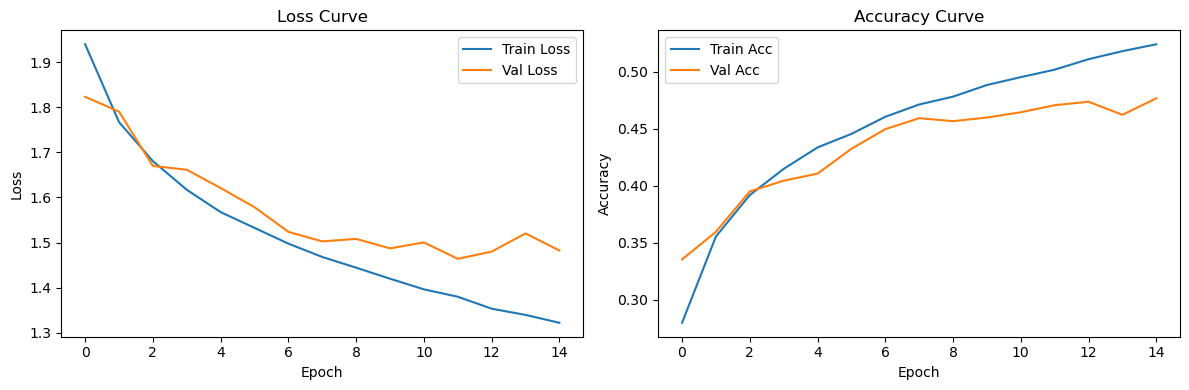

In [21]:
import matplotlib.pyplot as plt
# Plot loss and accuracy
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(relu_train_losses, label='Train Loss')
plt.plot(relu_val_losses, label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(relu_train_accuracies, label='Train Acc')
plt.plot(relu_val_accuracies, label='Val Acc')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

>🔎 What Are We Observing?

As you look at the curves, ask yourself:
- 📉 Is the loss decreasing steadily?
- 📈 Is accuracy increasing as expected?
- 😐 Or does it plateau early, improve very slowly, or fluctuate?
- 😱 Are there signs of instability (sudden spikes or drops)?

These behaviors help us detect issues in the learning process, even if we don’t yet know exactly why they occur.

>⚠️ Common Problems in Deep Networks

We’ll explore these in the next few sections:

| Problem             | Symptom in Curves                | Possible Cause       |
| ------------------- | -------------------------------- | -------------------- |
| Vanishing Gradients | Loss stays flat, low accuracy    | Gradients too small  |
| Exploding Gradients | Spikes in loss, erratic accuracy | Gradients too large  |
| Poor Initialization | Any of the above                 | Random weight scales |

---

### **4. How Do Activation Functions Impact Training?**

In deep neural networks, the choice of **activation function** plays a major role in:

- How well the model learns complex patterns (non-linearity),
- How **gradients flow** during backpropagation,
- Whether training is **stable** or suffers from **vanishing** or **exploding** gradients.

So far, we’ve been using **ReLU**, which is the most common activation. But how does it compare to alternatives like **Tanh**?

Let’s investigate by comparing training behavior with the **same network architecture**, but a different activation function.

> **ReLU vs. Tanh — A Quick Recap**

**ReLU (Rectified Linear Unit)**: ReLU is simple: it outputs the input if it’s positive, and 0 otherwise. This means neurons are "active" only when they see positive signals. Think of a ReLU neuron like a light switch that turns on only for positive values — simple and efficient.

Why ReLU works well:
- Its gradient is either **0 or 1**, so gradients don’t shrink as easily.
- It **avoids saturation** — there’s no upper cap like Tanh or Sigmoid.
- **Training is usually faster** and more stable with ReLU.

However, some neurons might "die" if they only receive negative inputs forever — these never activate and stop learning. This is called the **Dying ReLU problem**.

**Tanh (Hyperbolic Tangent)**: Tanh squashes inputs to the range between **-1 and 1**. It’s **symmetric around zero**, which can help early in training. Think of Tanh as a soft squashing spring — it compresses all signals to stay within a narrow zone.

But here's the issue:
- In deep networks, after several layers, signals can get **squashed too much**.
- This causes **gradients to shrink** as they move backward — a problem known as the **vanishing gradient**.
- The network struggles to learn because the updates become too tiny.

In summary, ReLU is like a sharp-edged filter: fast, sparse, and generally stable — but watch for inactive neurons. Tanh is smooth and bounded — better for shallow nets, but not great for deep ones due to vanishing gradients.

>**Our Experiment: Same Network, Different Activations**

We’ve already trained our **5-hidden-layer MLP with ReLU** in the previous section.

Let’s now define an **identical architecture** but replace `ReLU` with `Tanh`.

We’ll train it under the same conditions (optimizer, epochs, batch size) and compare **loss and accuracy curves**.

In [24]:
class DeepMLP_Tanh(nn.Module):
    def __init__(self, input_dim=32*32*3, hidden_dim=128, output_dim=len(class_names)):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)
    
# Instantiate the model
tanh_deep_mlp = DeepMLP_Tanh()
print(tanh_deep_mlp)

DeepMLP_Tanh(
  (net): Sequential(
    (0): Linear(in_features=3072, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Tanh()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): Tanh()
    (10): Linear(in_features=128, out_features=10, bias=True)
  )
)


**Train the Tanh-Based Network**

In [25]:
# Instantiate and train Tanh-based model
tanh_train_losses, tanh_val_losses, tanh_train_accuracies, tanh_val_accuracies = train_deep_model(
    tanh_deep_mlp, train_loader, val_loader, epochs=15
)

Iterating Training batches: 100%|██████████| 704/704 [00:21<00:00, 32.04it/s]


Epoch [1/15] - Train Loss: 1.9822, Acc: 0.2634 | Val Loss: 1.9172, Acc: 0.2954


Iterating Training batches: 100%|██████████| 704/704 [00:21<00:00, 33.02it/s]


Epoch [2/15] - Train Loss: 1.8708, Acc: 0.3167 | Val Loss: 1.9346, Acc: 0.2948


Iterating Training batches: 100%|██████████| 704/704 [00:21<00:00, 33.41it/s]


Epoch [3/15] - Train Loss: 1.8486, Acc: 0.3320 | Val Loss: 1.8392, Acc: 0.3420


Iterating Training batches: 100%|██████████| 704/704 [00:21<00:00, 33.15it/s]


Epoch [4/15] - Train Loss: 1.8167, Acc: 0.3462 | Val Loss: 1.8197, Acc: 0.3482


Iterating Training batches: 100%|██████████| 704/704 [00:22<00:00, 31.84it/s]


Epoch [5/15] - Train Loss: 1.8009, Acc: 0.3558 | Val Loss: 1.9305, Acc: 0.3010


Iterating Training batches: 100%|██████████| 704/704 [00:45<00:00, 15.57it/s]


Epoch [6/15] - Train Loss: 1.7881, Acc: 0.3565 | Val Loss: 1.7890, Acc: 0.3602


Iterating Training batches: 100%|██████████| 704/704 [00:21<00:00, 32.59it/s]


Epoch [7/15] - Train Loss: 1.7555, Acc: 0.3680 | Val Loss: 1.7940, Acc: 0.3622


Iterating Training batches: 100%|██████████| 704/704 [00:21<00:00, 32.73it/s]


Epoch [8/15] - Train Loss: 1.7525, Acc: 0.3698 | Val Loss: 1.7598, Acc: 0.3636


Iterating Training batches: 100%|██████████| 704/704 [00:23<00:00, 30.20it/s]


Epoch [9/15] - Train Loss: 1.7403, Acc: 0.3767 | Val Loss: 1.7596, Acc: 0.3692


Iterating Training batches: 100%|██████████| 704/704 [00:21<00:00, 32.64it/s]


Epoch [10/15] - Train Loss: 1.7329, Acc: 0.3789 | Val Loss: 1.7585, Acc: 0.3526


Iterating Training batches: 100%|██████████| 704/704 [00:21<00:00, 32.36it/s]


Epoch [11/15] - Train Loss: 1.7174, Acc: 0.3830 | Val Loss: 1.7464, Acc: 0.3756


Iterating Training batches: 100%|██████████| 704/704 [00:21<00:00, 32.63it/s]


Epoch [12/15] - Train Loss: 1.7050, Acc: 0.3881 | Val Loss: 1.7257, Acc: 0.3832


Iterating Training batches: 100%|██████████| 704/704 [00:21<00:00, 32.82it/s]


Epoch [13/15] - Train Loss: 1.6941, Acc: 0.3936 | Val Loss: 1.7411, Acc: 0.3786


Iterating Training batches: 100%|██████████| 704/704 [00:22<00:00, 31.74it/s]


Epoch [14/15] - Train Loss: 1.6883, Acc: 0.3955 | Val Loss: 1.7283, Acc: 0.3782


Iterating Training batches: 100%|██████████| 704/704 [00:22<00:00, 31.89it/s]


Epoch [15/15] - Train Loss: 1.6899, Acc: 0.3925 | Val Loss: 1.7287, Acc: 0.3840
Training and validation time is: 355.3120269200008


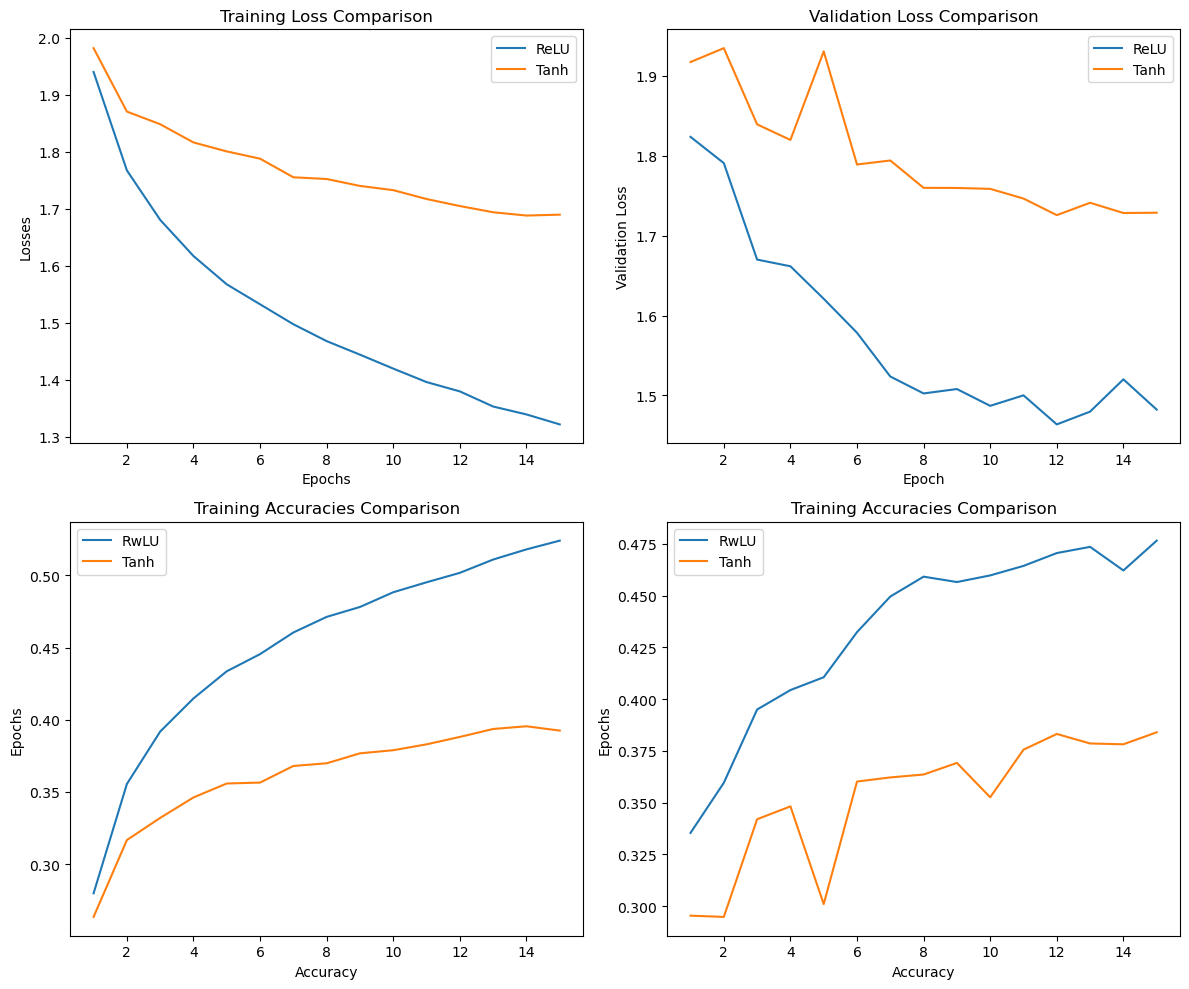

In [27]:
epochs = range(1, len(relu_train_accuracies) + 1)

plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.plot(epochs, relu_train_losses, label='ReLU')
plt.plot(epochs, tanh_train_losses, label='Tanh')
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend()

# Validation Loss
plt.subplot(2, 2, 2)
plt.plot(epochs, relu_val_losses, label="ReLU")  # from Section 3
plt.plot(epochs, tanh_val_losses, label="Tanh")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Comparison")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, relu_train_accuracies, label='RwLU')
plt.plot(epochs, tanh_train_accuracies, label='Tanh')
plt.title('Training Accuracies Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Epochs')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, relu_val_accuracies, label='RwLU')
plt.plot(epochs, tanh_val_accuracies, label='Tanh')
plt.title('Training Accuracies Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Epochs')
plt.legend()

plt.tight_layout()
plt.show()

>What Do We Observe?

- **ReLU** converges faster and reaches **higher accuracy** than Tanh.
- **Tanh** suffers from **slower learning** and **lower performance**, especially in deep networks.
- This is due to **vanishing gradients** caused by Tanh's saturation behavior (squashing values to -1 and 1).

>Key Takeaways

- In deep architectures, **ReLU is usually the better default**.
- Tanh and Sigmoid can cause vanishing gradients, especially when weights aren’t carefully initialized.
- We’ll revisit activation functions again when we explore **Batch Normalization** and alternatives like **Leaky ReLU** and **ELU** in later notebooks.

➡️ Next up: Let’s look at the **flow of gradients** to diagnose why deep models struggle — and how we can fix it!

---

### **5. How Do Gradients Behave in Deep Networks?**

In Section 3, we observed that deeper MLPs can be surprisingly hard to train. But why does that happen?

One major culprit is poor gradient flow. Let's understand this through intuition and code.
⚡ What Is Gradient Flow?

When we backpropagate errors during training, gradients flow from the output layer to earlier layers.

If gradients are:

- Very small (close to 0): early layers learn very little.
    → This is called the vanishing gradient problem.

- Very large: weights change erratically, leading to instability.
    → This is called the exploding gradient problem.

Both issues make training slow, unstable, or completely ineffective.

> 📊 Let's Visualize Gradient Norms

We’ll now:

- Track the L2 norm of gradients for each layer after every epoch.
- Plot how these norms evolve over time.
- See if earlier layers suffer from vanishing or exploding gradients.

This will help us diagnose training challenges caused by poor initialization or unsuitable activations.

**Track Gradient Norms Across All Layers**

In [28]:
def track_gradient_norms(model, train_loader, num_epochs=10, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    gradient_history = []

    for epoch in range(num_epochs):
        model.train()

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            # Record L2 Norm of gradients for each layers
            grad_norms = list()
            for params in model.parameters():
                if params.grad is not None:
                    grad_norm = params.grad.detach().norm(2).item()
                    grad_norms.append(grad_norm)
            gradient_history.append(grad_norms)
            optimizer.step()
            break  # Only one batch per epoch for gradient tracking (faster)

        print(f"Epoch {epoch+1}/{num_epochs} ✅ Gradient norms tracked.")

    return gradient_history

In [29]:
import numpy as np
def plot_gradient_norms(gradient_history):
    

    grad_array = np.array(gradient_history)  # shape: (epochs, num_params)
    plt.figure(figsize=(10, 6))

    for i in range(grad_array.shape[1]):
        plt.plot(grad_array[:, i], label=f"Layer {i+1}")

    plt.title("Gradient Norms Across Layers (Over Epochs)")
    plt.xlabel("Epochs")
    plt.ylabel("Gradient L2 Norm")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()


In [35]:
def track_gradient_norms(
        model, train_loader, num_epochs, lr=0.001
):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # set devive and move model to device available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    gradient_history = []
    for epoch in range(num_epochs):
        model.train()

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()

            grad_norms = []
            for name, params in model.named_parameters():
                if 'weight' in name and params.grad is not None:
                    grad_norm = params.grad.detach().norm(2).item()
                    grad_norms.append(grad_norm)
            gradient_history.append(grad_norms)
            break
        print(f"Epoch {epoch+1}/{num_epochs} ✅ Tracked {len(grad_norms)} weight gradients.")
    return gradient_history

In [32]:
for name, params in tanh_deep_mlp.named_parameters():
    if 'weight' in name and params.grad is not None:
        print(name, '\n', params.grad.detach().norm(2))

net.0.weight 
 tensor(1.2940)
net.2.weight 
 tensor(0.4147)
net.4.weight 
 tensor(0.2030)
net.6.weight 
 tensor(0.2889)
net.8.weight 
 tensor(0.4366)
net.10.weight 
 tensor(1.6973)


In [36]:
def plot_gradient_norms(gradient_history):
    import numpy as np
    import matplotlib.pyplot as plt

    grad_array = np.array(gradient_history)  # shape: (epochs, num_layers)
    plt.figure(figsize=(10, 6))

    line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 5))]  # 6 distinct styles

    for i in range(grad_array.shape[1]):
        label = f"Layer {i+1}: Linear"
        plt.plot(grad_array[:, i], linestyle=line_styles[i % len(line_styles)], label=label)

    plt.title("Weight Gradient Norms Across Layers (Over Epochs)")
    plt.xlabel("Epoch")
    plt.ylabel("L2 Norm of Gradient")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Epoch 1/15 ✅ Tracked 6 weight gradients.
Epoch 2/15 ✅ Tracked 6 weight gradients.
Epoch 3/15 ✅ Tracked 6 weight gradients.
Epoch 4/15 ✅ Tracked 6 weight gradients.
Epoch 5/15 ✅ Tracked 6 weight gradients.
Epoch 6/15 ✅ Tracked 6 weight gradients.
Epoch 7/15 ✅ Tracked 6 weight gradients.
Epoch 8/15 ✅ Tracked 6 weight gradients.
Epoch 9/15 ✅ Tracked 6 weight gradients.
Epoch 10/15 ✅ Tracked 6 weight gradients.
Epoch 11/15 ✅ Tracked 6 weight gradients.
Epoch 12/15 ✅ Tracked 6 weight gradients.
Epoch 13/15 ✅ Tracked 6 weight gradients.
Epoch 14/15 ✅ Tracked 6 weight gradients.
Epoch 15/15 ✅ Tracked 6 weight gradients.


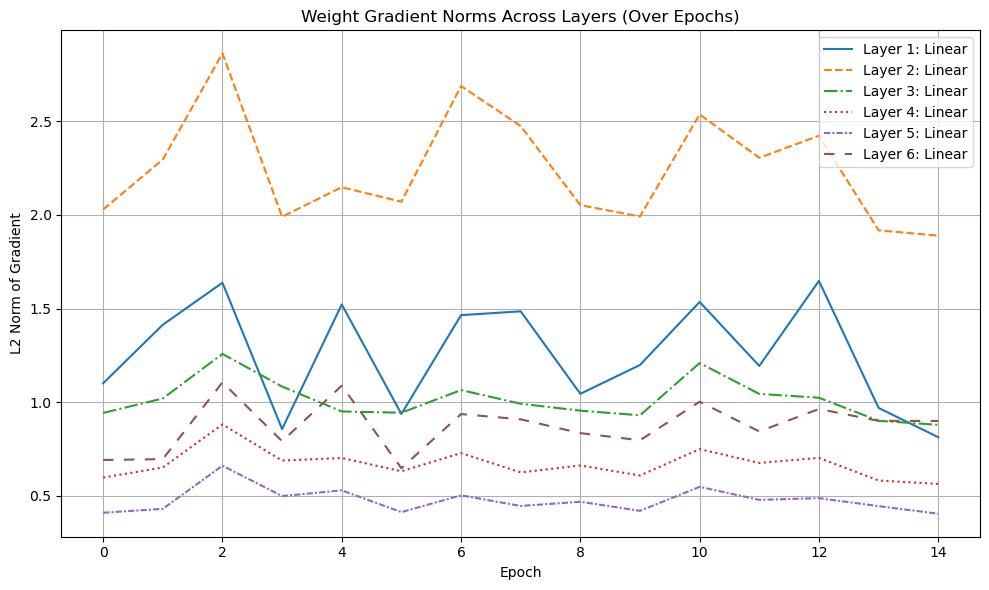

In [37]:
# Use our original deep MLP (with default init)
gradient_history = track_gradient_norms(relu_deep_mlp, train_loader, num_epochs=15)
plot_gradient_norms(gradient_history)

**Interpreting Gradient Norms Across Layers**

This plot shows the **L2 norm of weight gradients** for each linear layer over 15 training epochs. These norms indicate **how strongly each layer is learning** at each step.

>📌 **Layer Mapping**
- **Layer 1**: Input → First Hidden Layer
- **Layer 2 to 5**: Subsequent Hidden Layers
- **Layer 6**: Last Hidden Layer → Output Layer

**🧠 What Do the Curves Tell Us?**

- Layers with **higher gradient norms** are updating more — this means their weights are receiving stronger learning signals.
- Layers with **very small or flat gradients** may be experiencing the **vanishing gradient problem**.
- If a layer’s gradients become **too large or spiky**, it may indicate **exploding gradients**, leading to instability.

> For example:
- If **earlier layers** (closer to the input) show tiny gradients, it means learning is not effectively reaching them.
- If the **last layer** dominates the update signals, the network may rely too much on the last transformation, limiting learning depth.

>🔬 Why This Matters

- Deep networks **rely on good gradient flow** to learn across all layers.
- Poor flow = some layers don't learn much = shallow effective capacity despite deep architecture.
- We’ll soon explore **weight initialization strategies** (like Xavier and He) designed to **preserve gradient magnitudes**, allowing deeper layers to learn effectively.

---

**✅ Code Task 4.2.5.1: Track Gradient Norms for One Batch**

📘 Goal: Compute and print L2 norms of gradients for weight layers only after one backward pass.

In [38]:
# Task 5.1 – Track gradient norms for one batch

# Re-instantiate model for gradient tracking
CT_model_grad = DeepMLP()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CT_model_grad.to(device)

# Loss and optimizer
CT_criterion_grad = nn.CrossEntropyLoss()
CT_optimizer_grad = optim.Adam(CT_model_grad.parameters(), lr = 0.001)

# Get one batch
CT_images_grad, CT_labels_grad = next(iter(train_loader))
CT_images_grad, CT_labels_grad = CT_images_grad.to(device), CT_labels_grad.to(device)

# Forward pass
CT_outputs_grad = CT_model_grad(CT_images_grad)
CT_loss_grad = CT_criterion_grad(CT_outputs_grad, CT_labels_grad)

# Backward pass
CT_optimizer_grad.zero_grad()
CT_loss_grad.backward()

# Record L2 norms for weights
CT_grad_norms = []
for CT_name, CT_param in CT_model_grad.named_parameters():
    if "weight" in CT_name and CT_param.grad is not None:
        CT_grad_norms.append(CT_param.grad.detach().norm(2).item())

print("CT_Gradient Norms (first batch):", CT_grad_norms)


CT_Gradient Norms (first batch): [0.03518517315387726, 0.0063635860569775105, 0.007647922728210688, 0.0105654988437891, 0.019963718950748444, 0.05363824963569641]


### **6. Why Do We Need Better Weight Initialization?**

In the previous section, we saw that training our deep MLP showed **uneven gradient flow** — some layers received strong updates, others barely learned at all. This wasn't a bug in our optimizer or data — the real culprit lies in **how the model was initialized**.

Let’s unpack this.

> 🧠 **The Problem with Default Initialization in PyTorch**

When we define a model using `nn.Linear` layers in PyTorch, the weights are **automatically initialized** using a method called:

```python
nn.init.kaiming_uniform_  # a.k.a. He Uniform
```

This is **a variant of He Initialization**, designed for **ReLU-based activations**, and is a solid choice *if* we use ReLU.

But here's the catch:

> 🔎 PyTorch applies this **regardless of the activation** we plan to use later.

This means:
- Even if we use **Tanh** (or **Sigmoid**), the layers still get initialized with **He Uniform**.
- But He initialization is **not well-suited** for these activations — and this mismatch leads to **poor learning** in deep networks.

>**Why Mismatched Initialization Breaks Training**

Let’s break down what happens with poor initialization choices:

**❌ Too Small Weights?**
- Activations shrink layer by layer.
- Gradients vanish during backpropagation.
- → **Vanishing gradients**: early layers stop learning.

**❌ Too Large Weights?**
- Activations explode as they pass through layers.
- Gradients grow uncontrollably.
- → **Exploding gradients**: unstable or diverging training.

These issues break the learning signal. Some layers dominate; others fall silent.

>🔍 What’s Actually Going Wrong?

Let’s say we start with an input vector **x** and pass it through many linear layers:

$$
\text{Layer 1: } x_1 = W_1 x \\
\text{Layer 2: } x_2 = W_2 x_1 \\
\text{... and so on}
$$

If the **variance** of activations or gradients grows or shrinks across layers, learning becomes unstable.  
We want each layer to **preserve the scale** of both:
- **Forward activations**
- **Backward gradients**

That’s where **smart initialization strategies** come in.

>**✅ Xavier and He: Designed to Preserve Variance**

Researchers proposed two initialization methods tailored to specific activation functions:

| Init Method | Designed For | Goal |
|-------------|--------------|------|
| **Xavier (Glorot)** | Tanh / Sigmoid | Preserve both forward and backward variance |
| **He (Kaiming)**    | ReLU / Leaky ReLU | Compensate for zeroed-out negative values |


</br>

>🔄 Think of Initialization Like Pouring Water Through Pipes

Let’s use a plumbing analogy:

- Each layer is a **pipe**.
- If a pipe is **too narrow** (small weights) → water trickles → **vanishing gradients**.
- If it’s **too wide** (large weights) → it floods → **exploding gradients**.
- A good initialization **sizes each pipe just right**, based on how many inputs/outputs it connects.

>**📌Xavier (Glorot) Initialization**

- Designed for symmetric activations like **Tanh** and **Sigmoid**.
- Assumes we want to preserve **equal variance** in both directions (forward & backward).
- Balances the scale by averaging the number of inputs and outputs.

**Formula (Uniform distribution):**

$$
W \sim \mathcal{U}\left[-\frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}, \frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}\right]
$$

💡 Think of it as: “Let’s keep the flow steady in both directions — no shrinking, no growing.”

🧪 In this notebook, we use **Tanh** to demonstrate this. But you can also try **Sigmoid** — it benefits from Xavier for the same reason.

👉 **If you want to try Sigmoid**, change the activation in your model from `Tanh()` to `Sigmoid()` — and use Xavier initialization just the same.

>**📌He (Kaiming) Initialization**

- Built for **ReLU-based** activations.
- ReLU discards all negative inputs — so signal is lost.
- He initialization compensates by increasing weight variance slightly.

> 🧮 **He Initialization: Two Variants**

There are **two forms** of He initialization depending on the distribution used:

1. **He Normal**

Weights are drawn from a **normal distribution**:

$$
W \sim \mathcal{N}\left(0, \frac{2}{n_{in}}\right)
$$

This is what we typically refer to when we say "He Initialization" in most theoretical discussions.

2. **He Uniform**

Weights are drawn from a **uniform distribution** over the range:

$$
W \sim \mathcal{U}\left[-\sqrt{\frac{6}{n_{in}}}, \sqrt{\frac{6}{n_{in}}} \right]
$$

This variant is used by **default in PyTorch** for `nn.Linear` layers when using ReLU.

> ✅ If we write:
```python
nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
```
PyTorch will automatically apply He Uniform tailored for ReLU.

> 🎯 In summary:

| Variant        | Distribution Type | Formula | When to Use         |
|----------------|-------------------|---------|----------------------|
| **He Normal**  | Normal            | 𝑁(0, 2/𝑛ᵢₙ) | When you want to explore theoretical or experimental variations |
| **He Uniform** | Uniform           | 𝕌[−√(6/𝑛ᵢₙ), √(6/𝑛ᵢₙ)] | PyTorch's default for ReLU activations |

**As we said, if we don’t explicitly set initialization, PyTorch by default uses He Uniform.**

Which means:
- If you're using **ReLU**, this default is **okay** (though not optimal).
- If you're using **Tanh** or **Sigmoid**, this is **mismatched** — use Xavier instead!

With the right initialization:
- Activations stay within a healthy range — no NaNs or zeros.
- Gradients propagate cleanly to early layers.
- Training becomes **faster**, **more stable**, and **more effective**.

In the next section, we’ll apply these initializations to our deep MLP and compare how:
- **Default ReLU (He Uniform)** stacks up against **He Normal**
- And how **Default Tanh (He Uniform 🤯)** compares to **Xavier Uniform**

➡️ Let’s measure the difference in learning — starting from just how we set the weights.

---

### **7. Apply Xavier and He Initialization to Deep MLP**

Now that we understand why **proper initialization is crucial**, let’s apply **Xavier** and **He** initialization methods explicitly and compare them with the **default initialization used by PyTorch**.

>Recap: 🔍 What’s the Default Initialization in PyTorch?

By default, PyTorch initializes weights for `nn.Linear` using:

- **He Uniform** for ReLU activations:
  ```python
  nn.init.kaiming_uniform_(weight, nonlinearity='relu')
  ```
- This helps ReLU networks stay stable during training.

But we **never made this explicit**, and we **never tried the alternative: He Normal**.

> So here, we will **manually re-initialize weights** to compare:
> - He Uniform (PyTorch default for ReLU)  
> - He Normal (theoretical form, used in many papers)  
> - Xavier Uniform (recommended for Tanh or Sigmoid)

>**🧪 What We'll Test**

| Model | Activation | Initialization |
|-------|------------|----------------|
| ✅ **Default ReLU MLP** | ReLU | PyTorch Default = He Uniform |
| ✅ **He Normal MLP**    | ReLU | He Normal (𝑁(0, 2/𝑛ᵢₙ)) |
| ✅ **Default Tanh MLP** | Tanh | PyTorch Default = He Uniform (suboptimal) |
| ✅ **Xavier MLP**       | Tanh | Xavier Uniform (𝕌[−√6/√(n_in + n_out), √6/√(n_in + n_out)]) |

</br>

> ℹ️ We only test **Tanh**, but the same logic applies to **Sigmoid** — Xavier should be used with both, since they squash values into narrow ranges.

**🛠️ Step 1: Define Custom Initialization Function**

In [42]:
def initialize_weights(model, method='xavier'):
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            if method == 'xavier':
                nn.init.xavier_uniform_(layer.weight)
            elif method == 'he_normal':
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
            elif method == 'he_uniform':
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
            else:
                raise ValueError('Unsupported init method')

**🛠️ Step 2: Create Models and Apply Init**

In [43]:
# ReLU MLP using He Normal
he_mlp = DeepMLP()  # same arch as before
initialize_weights(he_mlp, method="he_normal")

# Tanh MLP using Xavier
xavier_mlp = DeepMLP_Tanh()  # same arch as before
initialize_weights(xavier_mlp, method="xavier")

**🏋️ Step 3: Train All Models**

In [44]:
# He Init (Normal)
he_train_losses, he_val_losses, he_train_accuracies, he_val_accuracies = train_deep_model(
    he_mlp, train_loader, val_loader, num_epochs=15)

# Xavier Init
xavier_train_losses, xavier_val_losses, xavier_train_accuracies, xavier_val_accuracies = train_deep_model(
    xavier_mlp, train_loader, val_loader, num_epochs=15)

Iterating Training batches: 100%|██████████| 704/704 [00:25<00:00, 28.13it/s]


Epoch [1/15] - Train Loss: 1.9188, Acc: 0.2987 | Val Loss: 1.7745, Acc: 0.3552


Iterating Training batches: 100%|██████████| 704/704 [00:37<00:00, 18.74it/s]


Epoch [2/15] - Train Loss: 1.7324, Acc: 0.3738 | Val Loss: 1.7219, Acc: 0.3810


Iterating Training batches: 100%|██████████| 704/704 [00:33<00:00, 21.29it/s]


Epoch [3/15] - Train Loss: 1.6501, Acc: 0.4046 | Val Loss: 1.6050, Acc: 0.4250


Iterating Training batches: 100%|██████████| 704/704 [00:31<00:00, 22.22it/s]


Epoch [4/15] - Train Loss: 1.5961, Acc: 0.4258 | Val Loss: 1.6132, Acc: 0.4232


Iterating Training batches: 100%|██████████| 704/704 [00:22<00:00, 31.76it/s]


Epoch [5/15] - Train Loss: 1.5521, Acc: 0.4430 | Val Loss: 1.5882, Acc: 0.4302


Iterating Training batches: 100%|██████████| 704/704 [00:21<00:00, 32.78it/s]


Epoch [6/15] - Train Loss: 1.5320, Acc: 0.4513 | Val Loss: 1.5988, Acc: 0.4288


Iterating Training batches: 100%|██████████| 704/704 [00:27<00:00, 25.76it/s]


Epoch [7/15] - Train Loss: 1.5000, Acc: 0.4619 | Val Loss: 1.6054, Acc: 0.4212


Iterating Training batches: 100%|██████████| 704/704 [00:23<00:00, 29.71it/s]


Epoch [8/15] - Train Loss: 1.4699, Acc: 0.4706 | Val Loss: 1.5351, Acc: 0.4464


Iterating Training batches: 100%|██████████| 704/704 [00:21<00:00, 32.64it/s]


Epoch [9/15] - Train Loss: 1.4469, Acc: 0.4781 | Val Loss: 1.5058, Acc: 0.4578


Iterating Training batches: 100%|██████████| 704/704 [00:21<00:00, 32.94it/s]


Epoch [10/15] - Train Loss: 1.4346, Acc: 0.4851 | Val Loss: 1.5203, Acc: 0.4526


Iterating Training batches: 100%|██████████| 704/704 [00:21<00:00, 32.87it/s]


Epoch [11/15] - Train Loss: 1.4151, Acc: 0.4904 | Val Loss: 1.4862, Acc: 0.4762


Iterating Training batches: 100%|██████████| 704/704 [00:22<00:00, 30.79it/s]


Epoch [12/15] - Train Loss: 1.3943, Acc: 0.4990 | Val Loss: 1.5359, Acc: 0.4550


Iterating Training batches: 100%|██████████| 704/704 [00:21<00:00, 32.60it/s]


Epoch [13/15] - Train Loss: 1.3770, Acc: 0.5054 | Val Loss: 1.5087, Acc: 0.4586


Iterating Training batches: 100%|██████████| 704/704 [00:21<00:00, 32.29it/s]


Epoch [14/15] - Train Loss: 1.3657, Acc: 0.5083 | Val Loss: 1.5673, Acc: 0.4444


Iterating Training batches: 100%|██████████| 704/704 [00:24<00:00, 29.31it/s]


Epoch [15/15] - Train Loss: 1.3458, Acc: 0.5165 | Val Loss: 1.5025, Acc: 0.4678
Training and validation time is: 399.83177174400043


Iterating Training batches: 100%|██████████| 704/704 [00:17<00:00, 40.85it/s]


Epoch [1/15] - Train Loss: 1.9700, Acc: 0.2777 | Val Loss: 1.8954, Acc: 0.3060


Iterating Training batches: 100%|██████████| 704/704 [00:17<00:00, 39.99it/s]


Epoch [2/15] - Train Loss: 1.8451, Acc: 0.3280 | Val Loss: 1.9517, Acc: 0.3012


Iterating Training batches: 100%|██████████| 704/704 [00:17<00:00, 40.74it/s]


Epoch [3/15] - Train Loss: 1.8059, Acc: 0.3464 | Val Loss: 1.8056, Acc: 0.3496


Iterating Training batches: 100%|██████████| 704/704 [00:17<00:00, 41.11it/s]


Epoch [4/15] - Train Loss: 1.7748, Acc: 0.3563 | Val Loss: 1.8174, Acc: 0.3522


Iterating Training batches: 100%|██████████| 704/704 [00:17<00:00, 40.55it/s]


Epoch [5/15] - Train Loss: 1.7590, Acc: 0.3642 | Val Loss: 1.7979, Acc: 0.3530


Iterating Training batches: 100%|██████████| 704/704 [00:17<00:00, 40.74it/s]


Epoch [6/15] - Train Loss: 1.7462, Acc: 0.3676 | Val Loss: 1.7562, Acc: 0.3742


Iterating Training batches: 100%|██████████| 704/704 [00:17<00:00, 40.49it/s]


Epoch [7/15] - Train Loss: 1.7280, Acc: 0.3768 | Val Loss: 1.7384, Acc: 0.3794


Iterating Training batches: 100%|██████████| 704/704 [00:17<00:00, 40.56it/s]


Epoch [8/15] - Train Loss: 1.7145, Acc: 0.3811 | Val Loss: 1.7304, Acc: 0.3754


Iterating Training batches: 100%|██████████| 704/704 [00:17<00:00, 40.90it/s]


Epoch [9/15] - Train Loss: 1.6965, Acc: 0.3872 | Val Loss: 1.7411, Acc: 0.3794


Iterating Training batches: 100%|██████████| 704/704 [00:17<00:00, 40.77it/s]


Epoch [10/15] - Train Loss: 1.6933, Acc: 0.3909 | Val Loss: 1.7436, Acc: 0.3704


Iterating Training batches: 100%|██████████| 704/704 [00:17<00:00, 40.80it/s]


Epoch [11/15] - Train Loss: 1.6854, Acc: 0.3951 | Val Loss: 1.7143, Acc: 0.3766


Iterating Training batches: 100%|██████████| 704/704 [00:17<00:00, 40.75it/s]


Epoch [12/15] - Train Loss: 1.6683, Acc: 0.3987 | Val Loss: 1.6766, Acc: 0.4024


Iterating Training batches: 100%|██████████| 704/704 [00:17<00:00, 40.74it/s]


Epoch [13/15] - Train Loss: 1.6607, Acc: 0.4018 | Val Loss: 1.7246, Acc: 0.3864


Iterating Training batches: 100%|██████████| 704/704 [00:17<00:00, 40.77it/s]


Epoch [14/15] - Train Loss: 1.6586, Acc: 0.4051 | Val Loss: 1.6929, Acc: 0.3940


Iterating Training batches: 100%|██████████| 704/704 [00:17<00:00, 40.46it/s]


Epoch [15/15] - Train Loss: 1.6571, Acc: 0.4034 | Val Loss: 1.6694, Acc: 0.4086
Training and validation time is: 278.8907951049987


**📊 Step 4a: Visualize Results - ReLU**

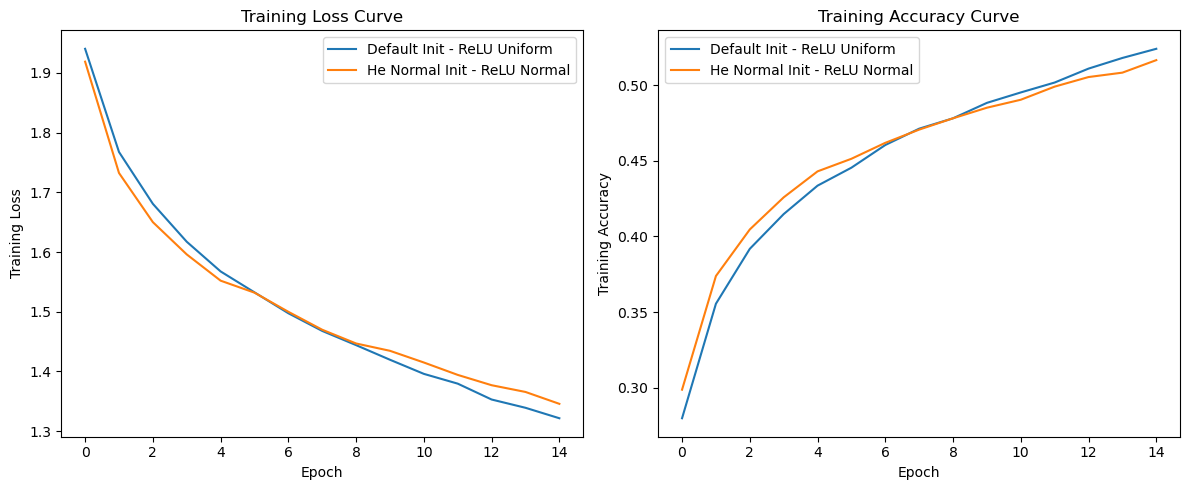

In [45]:
# Plot train loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(relu_train_losses, label='Default Init - ReLU Uniform')
plt.plot(he_train_losses, label='He Normal Init - ReLU Normal')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Curve")
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(relu_train_accuracies, label='Default Init - ReLU Uniform')
plt.plot(he_train_accuracies, label='He Normal Init - ReLU Normal')
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

**📊 Step 4b: Visualize Results - Tanh**

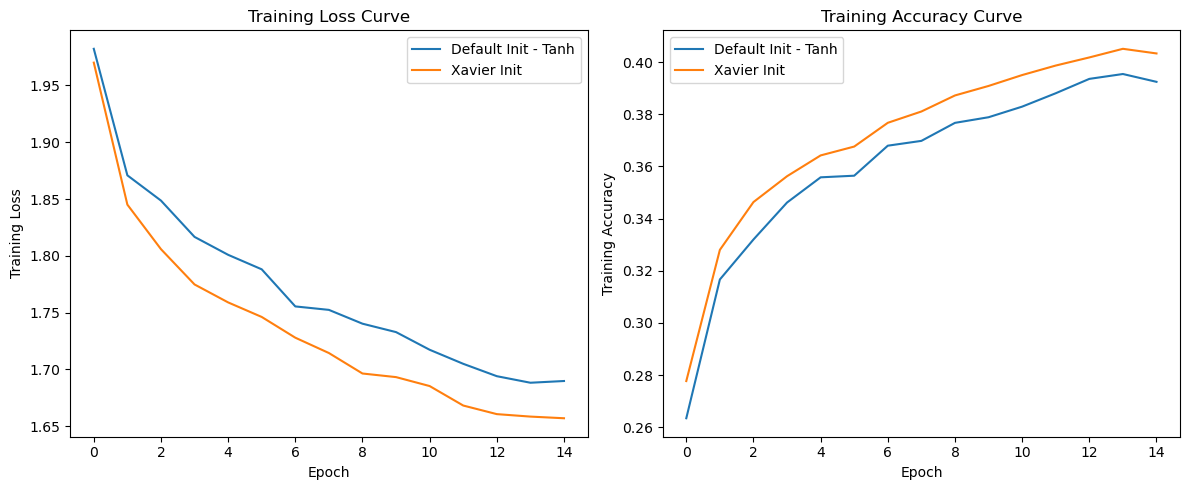

In [46]:
# Plot train loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(tanh_train_losses, label='Default Init - Tanh')
plt.plot(xavier_train_losses, label='Xavier Init')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Curve")
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(tanh_train_accuracies, label='Default Init - Tanh')
plt.plot(xavier_train_accuracies, label='Xavier Init')
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

We have now compared:

- **He Normal Init** vs. **Default Init (He Uniform)** for ReLU
- **Xavier Init** vs. **Default Init (He Uniform)** for Tanh

>**🧪 ReLU-Based Deep MLP**

| Observation | Insight |
|-------------|---------|
| 🔵 **Default Init - ReLU Uniform** and 🟠 **He Normal** show **very similar performance** in both training loss and accuracy. | This is expected — because PyTorch’s default for `nn.Linear` + ReLU is already **He Uniform**, which is well-suited for ReLU. |
| No clear gain from switching to **He Normal**. | While both preserve gradient flow, the difference between **uniform** and **normal** sampling is often minimal in practice. |

✅ **Conclusion**: For ReLU activations, PyTorch’s default initialization is already well-optimized. Explicit He Normal init shows similar outcomes.

>**🧪 Tanh-Based Deep MLP**

| Observation | Insight |
|-------------|---------|
| 🔵 **Default Init - Tanh** underperforms on both training loss and accuracy. | This is because the default He Uniform is **not suitable for Tanh**, which needs symmetric gradient handling. |
| 🟠 **Xavier Init** converges **faster** and achieves **better accuracy**. | Xavier was designed to preserve both forward and backward variance — making it ideal for symmetric activations like Tanh or Sigmoid. |

✅ **Conclusion**: For **Tanh (or Sigmoid)** activations, using **Xavier Initialization** gives clear improvements over the default.

---


**✅ Code Task 4.2.7.1: Apply Xavier and He Initialization**

📘 Goal: Apply Xavier and He initializations to two new models and confirm initialization type.

In [47]:
# Task 7.1 – Apply Xavier and He initialization to models

# Instantiate two models
CT_model_xavier = DeepMLP()
CT_model_he = DeepMLP_Tanh()

# Apply Xavier to first model
initialize_weights(CT_model_xavier, method="xavier")

# Apply He Normal to second model
initialize_weights(CT_model_he, method="he_normal")

# Print confirmation
print("CT_Xavier initialization applied to model_xavier.")
print("CT_He Normal initialization applied to model_he.")


CT_Xavier initialization applied to model_xavier.
CT_He Normal initialization applied to model_he.


### **🧠 8. Summary: What Did We Learn About Initialization?**

Training deep networks is **not just about adding more layers** — it’s about ensuring that **information flows effectively** through the network, both forward (activations) and backward (gradients).

And that flow starts with a single, critical choice:  
> **How do we initialize the weights?**

**🔍 What Our Experiments Showed**

- Models using **default initialization** (He Uniform) did *okay* with **ReLU**, but struggled badly with **Tanh**.
- With **Xavier** (for Tanh) and **He Normal** (for ReLU), we saw:
  - 🔄 **Faster and more stable learning**
  - ✅ **Higher training and validation accuracy**
- **Tanh + Xavier** clearly outperformed **Tanh + default init**, confirming the importance of **activation-aware initialization**.
- With ReLU, both **He Normal** and **default He Uniform** performed similarly — as expected.

**🧠 Why Does This Happen?**

Training is all about **signal propagation**:  
- If activations shrink or grow across layers, so do gradients.
- Poor initialization → **vanishing or exploding gradients** → slow or unstable learning.

Good initializations like **Xavier** and **He** solve this by:
- Controlling the **variance of weights**
- Preserving **activation and gradient magnitudes** from layer to layer
- Adapting to the **activation function** used in the network

**🧰 Practical Takeaways**

| Situation                           | Recommended Init  | Why It Helps                          |
|------------------------------------|-------------------|----------------------------------------|
| Using **Tanh** or **Sigmoid**      | Xavier            | Symmetric variance flow (fwd & back)   |
| Using **ReLU / Leaky ReLU**        | He                | Compensates for ReLU's zeroing effect  |
| Shallow Network (1–2 layers)       | Any (less critical) | Still useful, but less risk            |
| Deep Network (4+ layers)           | Xavier or He      | Crucial for gradient stability         |

</br>

> **💡 Rule of Thumb: Match your **initialization** to your **activation**.**

**🔭 What’s Next?**

Even with smart initialization, training can still be **slow, noisy, or unstable** — especially in deeper architectures.

In the next notebook, we’ll explore new tools that take training stability to the next level:
- ⚖️ **Batch Normalization** to smooth layer inputs  
- 🔁 **Adaptive optimizers** like Adam and RMSProp  
- 🧯 **Regularization** (Dropout, L2) to reduce overfitting
